# Titanic Machine Learning

This notebook shows my first attempt at the Titanic Challenge. Much is based off https://www.kaggle.com/startupsci/titanic-data-science-solutions and https://www.kaggle.com/omarelgabry/a-journey-through-titanic, with minor alterations in feature engineering. All scikit-learn tools use defaults. 

Accuracy of >90% is achieved *BUT* both tutorials (and this notebook) use in-sample predictive accuracy, and perform rather poorly (<80%) in out-of-sample prediction on Kaggle's test data. In next notebooks, I will use proper cross-validation to assess models and improve feature selection & model settings. 

## Next steps/questions for exploration
- FIXME - having trouble installing xgboost
- https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
- Which scikit-learn algorithms have regularization built-in? (or is that a setting?)
- How can I design a learning curve? 
- which analytic methods can handle nonlinear relationships in features WITHOUT binning? I don't like turning fare and age into arbitrary bins
- need to remove one level of dummy. Is there a clever way to do it in the generalized function? Like see which dummy has the lowest (or most negative) correlation with the outcome? 
- Some other things to look into: 
    - http://datascience.stackexchange.com/questions/10805/does-scikit-learn-use-regularization-by-default/10806
    - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    - http://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
    - http://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting
    - http://scikit-learn.org/stable/modules/feature_selection.html
    - https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python	

### In general, how do I get a better workflow for testing feature & model selection, etc? Basically, I need to wrap the data processing into a manageable script, and have measures of in-sample and out-of-sample accuracy. Ideally a learning curve as well

In [1]:
# TODO - use Kaggle API
# pip install kaggle
# kaggle competitions download -c titanic

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!date

Sun Mar 18 19:14:43 PDT 2018


In [28]:
# machine learning
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier


#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Helpful functions

In [4]:
def bin_feature(df, feature, bins, visualize = False):
    df[f'{feature}Bin'] = pd.cut(df[feature], bins, right = False)
    df[f'{feature}Bin_Code'] = pd.cut(df[feature], bins, right = False, labels=list(range(0,len(bins) - 1)))
    
    assert(pd.isna(df[f'{feature}Id']).sum() == 0), f'NAs created by binning {feature}, check bins'
    
    if visualize:
        print(df[[f'{feature}Id', 'Survived']].groupby([f'{feature}Id'], as_index=False).mean().sort_values(by=f'{feature}Id', ascending=True))
        grid = sns.FacetGrid(df_train, size=5)
        grid.map(sns.pointplot, f'{feature}Id', 'Survived', 'Sex', palette='deep')
        grid.add_legend()
    
    return df

def make_feature_dummies(df, feature):
    dummies = pd.get_dummies(df[feature], prefix = feature)
    df = df.merge(dummies, left_index=True, right_index = True)
    return df
    
def count_missing_features(df):
    print(f'features with missing obs (n = {len(df.index)})')
    for col in df.columns:
        n_miss = pd.isna(df[col]).sum()
        if n_miss > 0: print(f'_{col}_ {n_miss}')
            
def check_for_any_na(df):
    missing_features = pd.isna(df).sum()
    n_miss = missing_features.sum() 
    if n_miss > 0: print(missing_features[missing_features > 0])
    assert (n_miss == 0), 'df has missing values'

In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
print(df_train.columns.values)
df_train.head()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Quick Examination of data

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fleming, Miss. Margaret",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
print("df_train")
count_missing_features(df_train) 
print('_'*40)
print("df_test")
count_missing_features(df_test) 

df_train
features with missing obs (n = 891)
_Age_ 177
_Cabin_ 687
_Embarked_ 2
________________________________________
df_test
features with missing obs (n = 418)
_Age_ 86
_Fare_ 1
_Cabin_ 327


# Visualize Data
## Basic Demographics

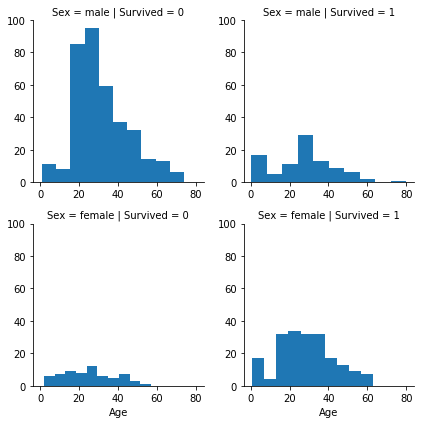

In [9]:
g = sns.FacetGrid(df_train, row = 'Sex', col='Survived')
g.map(plt.hist, 'Age', bins=10)
#g = sns.FacetGrid(df_train, row = 'Sex', col='Survived', hue = 'Pclass')
#g.map(sns.distplot, 'Age', bins=10, hist = False)
#g.add_legend()

## Survival by Class and Embarked

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


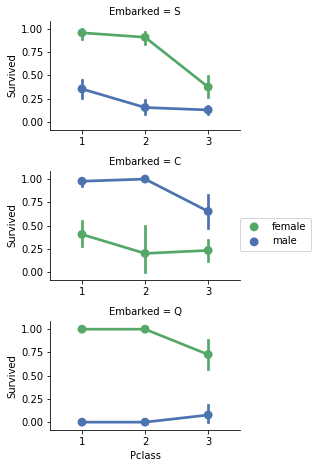

In [10]:
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


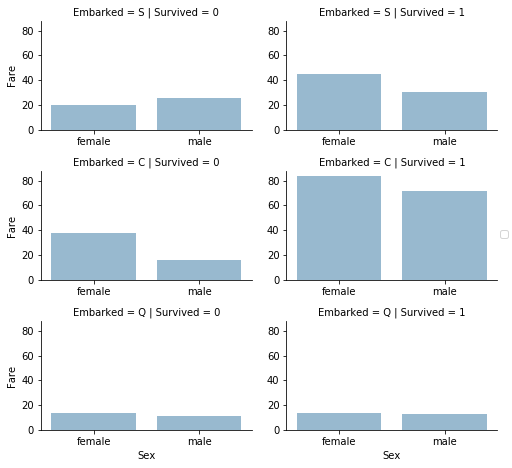

In [11]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# Complete Missing features
For now, just use overall median/mode. Further analyses can examine improvement by more complex imputation 

In [12]:
df_both = [df_train, df_test]

for dataset in df_both:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Age'] = dataset['Age'].astype(int)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    
# More complex imputation: imputing mean age by stratification. 

# grid = sns.FacetGrid(df_train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
# #grid = sns.FacetGrid(df_train, row='Title', col='Sex', size=2.2, aspect=1.6)
# grid.map(plt.hist, 'Age', alpha=.5, bins=20)
# grid.add_legend()

# guess_ages = np.zeros((2,3))

# df_both = [df_train, df_test]
# for dataset in df_both:
#     for i in range(0, 2):
#         for j in range(0, 3):
#             guess_df = dataset[(dataset['Sex'] == i) & \
#                                   (dataset['Pclass'] == j+1)]['Age'].dropna()

#             # age_mean = guess_df.mean()
#             # age_std = guess_df.std()
#             # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

#             age_guess = guess_df.median()

#             # Convert random age float to nearest .5 age
#             guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
#     for i in range(0, 2):
#         for j in range(0, 3):
#             dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
#                     'Age'] = guess_ages[i,j]

#     dataset['Age'] = dataset['Age'].astype(int)


# Feature Engineering
- `Title` from `Name`
- `FamilySize` from `SibSp` and `Parch`

In [13]:
title_mapping = {"Mr": "Mr", 
                 "Miss": "Miss", "Ms":"Miss", "Mlle": "Miss",
                 "Mrs": "Mrs", "Mme": "Mrs",
                 "Master": "Master"}

df_both = [df_train, df_test]
for dataset in df_both:
    dataset['Prefix'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # Potentially cleaner way (TODO: check that they produce same result)
    # dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    dataset['Title'] = dataset['Prefix'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna("Other")
    
df_test = make_feature_dummies(df_test, 'Title')
df_train = make_feature_dummies(df_train, 'Title')

# Convert to ordinal
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# for dataset in df_both:
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(0)

# pd.crosstab(df_train['Title'], df_train['Survived'], dropna = False)

In [14]:
df_both = [df_train, df_test]
for dataset in df_both:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
    
# df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean() #.sort_values(by='Survived', ascending=False)

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Bin Relevant Features

In [33]:
# equal bins (via basic pd functions)
for dataset in [df_train, df_test]:
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    dataset['FamilySizeBin'] = pd.cut(dataset['FamilySize'], bins = [1, 2, 5, 20], right = False)

# Custom bins (via my convenience function)

# Seems like 4 or less survive more (guessing it's a socioeconomic thing)
# BUT lonely males are not well off

# bins = [1, 2, 5, 20]
# df_train = bin_feature(df_train, 'FamilySize', bins, visualize=False)
# df_test = bin_feature(df_test, 'FamilySize', bins, visualize=False)

# bins = [0,12,50,120]
# df_train = bin_feature(df_train, 'Age', bins, convert_to_id = False, visualize=True)
# df_test = bin_feature(df_test, 'Age', bins, convert_to_id = False, visualize=False)

# # Visualize survival by age
# fig, axis1 = plt.subplots(1,1,figsize=(22,4))
# average_age = df_train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
# sns.barplot(x='Age', y='Survived', data=average_age)

## Make dummy variables (maybe later...)

In [ ]:
#NOTE - I was having trouble looping over the dataframes in the function. Maybe a reference vs copy issue

# df_train = make_feature_dummies(df_train, 'FamilySizeId')
# df_test = make_feature_dummies(df_test, 'FamilySizeId')

# df_train = make_feature_dummies(df_train, 'AgeId')
# df_test = make_feature_dummies(df_test, 'AgeId')

# df_train = make_feature_dummies(df_train, 'Embarked')
# df_test = make_feature_dummies(df_test, 'Embarked')

## Encode categorical features

In [35]:
label = LabelEncoder()
for dataset in [df_train, df_test]:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    dataset['FamilySizeBin_Code'] = label.fit_transform(dataset['FamilySizeBin'])

    #dataset['Sex_Code'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# Define analytic features

In [18]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Prefix', 'Title',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'FamilySize', 'IsAlone', 'FareBin', 'AgeBin', 'FamilySizeBin',
       'FamilySizeBin_Code', 'Sex_Code', 'Embarked_Code', 'Title_Code',
       'AgeBin_Code', 'FareBin_Code'],
      dtype='object')

In [39]:
#define y variable aka target/outcome
Target = ['Survived']

data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
# TODO: check using FamilySizeBin, Is_Alone, and other dummies/ custom bins!


# FamilySizeDummies = list(filter(lambda x:'FamilySizeId_' in x, df_train.columns.values.tolist()))
# AgeDummies = list(filter(lambda x:'AgeId_' in x, df_train.columns.values.tolist()))
# EmbarkedDummies = list(filter(lambda x:'Embarked_' in x, df_train.columns.values.tolist()))
# TitleDummies = list(filter(lambda x:'Title_' in x, df_train.columns.values.tolist()))
# dummies = FamilySizeDummies + AgeDummies + EmbarkedDummies + TitleDummies
# dummies

In [40]:
check_for_any_na(df_train[data1_x_bin])
check_for_any_na(df_test[data1_x_bin])

In [41]:
df_train[data1_x_bin].head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySizeBin_Code,AgeBin_Code,FareBin_Code
0,1,3,2,2,1,1,0
1,0,1,0,3,1,2,3
2,0,3,2,1,0,1,1
3,0,1,2,3,1,2,3
4,1,3,2,2,0,2,1


In [42]:
data1 = df_train

In [43]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    #XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.838202,0.828731,0.0443402,0.0510159
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.884831,0.824254,0.0501737,0.00173173
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.837079,0.823507,0.0500737,0.0619439
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.864794,0.823134,0.0453876,0.0642108
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.88015,0.822388,0.0513463,0.0160286
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.881648,0.822015,0.0354163,0.0149702
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.884831,0.819403,0.0498606,0.0140015
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.863858,0.818284,0.0418992,1.0329
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.82191,0.817164,0.0566378,0.0942998
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.884831,0.815299,0.0451246,0.00151579
